<a href="https://colab.research.google.com/github/vaguiar/camelyon_dl_2019/blob/cc_explore/working_with_starter_code_cc_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
## load data fom google drive 
from google.colab import drive
drive.mount('/content/drive')

In [0]:
base_dir = '/content/drive/My Drive/slides/'
CANCER_PATH = 'drive/My Drive/training_data/cancer'
NON_CANCER_PATH = 'drive/My Drive/training_data/non_cancer'
DISCARD_PATH = 'drive/My Drive/training_data/discard'


images = os.listdir(base_dir)
masks = [s for s in images if "_mask.tif" in s]
masks.sort()
slides = list(set([s for s in images if ".tif" in s]) - set(masks))
slides.sort()
slides.remove('tumor_038.tif')

masks_slides = zip(masks, slides)
masks_slides  = list(masks_slides)

In [0]:
def getSlide_Mask(slide_file, tumor_mask_file):

  slide_path = os.path.join(base_dir, slide_file)
  tumor_mask_path = os.path.join(base_dir, tumor_mask_file)


  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  
  for i in range(len(slide.level_dimensions)):
      assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  
  return slide, tumor_mask

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
  
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

  

  

def getTraining_Data(level, slide, tumor_mask, slide_width, slide_height, slide_file, 
                     min_x = 0, min_y = 0, cancer_thres = .3, tissue_thres = .1):
 

 
  '''
  use a sliding window filter of size (slide_height, slide_width) 
  save in cancer folder if more than 30% of pixels are cancerous 
  save in non_cancer folder if more than 10% of the slide is pixels 

  INPUT: 

  - level: image level to use
  - slide, 
  - tumor_mask, 
  - slide_width, 
  - slide_height, 
  - slide_file, 
  - min_x = 0, 
  - min_y = 0, 
  - cancer_thres = .3, 
  - tissue_thres = .1
  '''
  
 
  down_sample = int(slide.level_downsamples[level])
  pixel_width = int(down_sample*slide.level_dimensions[level][0])
  pixel_height = int(down_sample*slide.level_dimensions[level][1])
  
  # loop through image pixels 
  for x in range(min_x*down_sample, pixel_width, slide_width*down_sample):
    for y in range(min_y*down_sample, pixel_height, slide_height*down_sample):

      # calcualte slide width and slide height if image size starting at 
      # (x,y) is less than (slide_width, slide_height)
      slide_width_2 =  min(slide_width, slide.level_dimensions[level][0] - x/down_sample)
      slide_height_2 = min(slide_width, slide.level_dimensions[level][1] - y/down_sample)

      slide_image = read_slide(slide, 
                           x=x, 
                           y=y, 
                           level=level, 
                           width= int(slide_width_2) , 
                           height= int(slide_height_2) )
      
      
      # find % of tissues on slide_image
      tissue_pixels = find_tissue_pixels(slide_image)
      num_pixels = len(list(tissue_pixels))
      pcnt_tissue = num_pixels/ float(slide_image.shape[0] * slide_image.shape[0])


      mask_image = read_slide(tumor_mask,
                              x=x, 
                              y=y, 
                              level=level, 
                              width= int(slide_width_2) , 
                              height= int(slide_height_2) )

      mask_image = mask_image[:,:,0]

      # get % of cancer cells in mask 
      pcnt_cancer =  np.sum(mask_image)/((slide_width*slide_height)/100)
      
      # if % cancer > cancer_thres then save to cancer directory
      if pcnt_cancer >= cancer_thres:
        save_dir = CANCER_PATH 
        
      # if non-cancerous and percent of tissues is greater than tissue threshold
      # save to the non-cancerous directory
      elif ((pcnt_cancer <  cancer_thres) & (pcnt_tissue >= tissue_thres)):
        save_dir = NON_CANCER_PATH 
        
      # if the image is not a square do not save as it is likely the end of the slide 
      # this improves efficieny 
      elif slide_width_2 != slide_height_2:
        save_dir = DISCARD_PATH  
      else:
        save_dir = DISCARD_PATH 

      
      
      # save images if not meant to be discarded. 
      
      if save_dir == DISCARD_PATH:
        pass
      
      else: 
        name = save_dir + "/" + "level_" + str(level) + "_" + str(x) + "_" + str(y)+ "_" + slide_file

        print(pcnt_cancer, pcnt_tissue, name)
        plt.figure(figsize=(10,10), dpi=100)
        plt.imshow(slide_image)
        #plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
        plt.savefig(name)
        plt.close()




In [0]:
:slide_masks = masks_slides[12]
slide_file = slide_masks[1]
tumor_mask_file =slide_masks[0]
slide, tumor_mask = getSlide_Mask(slide_file, tumor_mask_file)

In [0]:
level = 3
slide_width = 600
slide_height = 600 

In [0]:
getTraining_Data(level, slide, tumor_mask, slide_width, slide_height, slide_file)

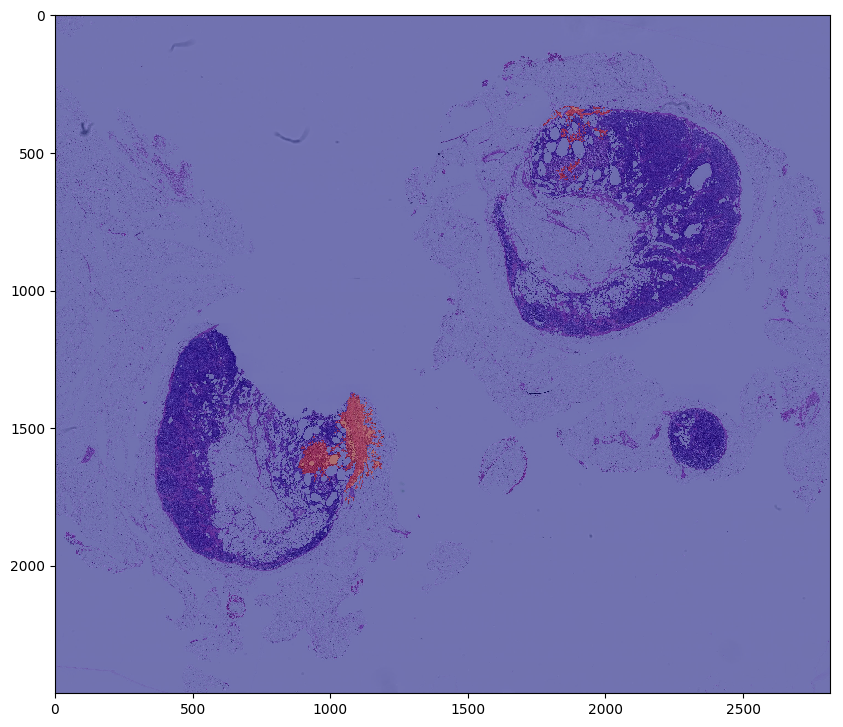

In [120]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])


# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])


# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.